In [1]:
import os
from pathlib import PosixPath
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib as mpl
from collections import OrderedDict

tqdm.pandas(ncols=50)

## Data preparation

In [2]:
df = None

for path in [
    'data/comparing_with_specialized/trained3_payloads_1000traj/*.csv',
]:

    for file in glob.glob(path):
        df_ = pd.read_csv(file, index_col=0)

        if df is None:
            df = df_
        else:
            # Merge rows
            df = pd.concat([df, df_], ignore_index=True)


def extend_columns(x):
    run_args = eval(x['run_args'])

    res = dict(
        command_x=run_args['command']['x'],
        command_y=run_args['command']['y'],
        command_t=run_args['command']['t'],
        command_h=run_args['command']['h'],
        terrain=run_args['env']['terrain'],
        force=run_args['env']['force'],
        policy=run_args['env']['policy'],
    )

    total_power = 0
    for i, power in enumerate(list(map(float, x['power'][1:-1].split()))):
        res[f'power_{i}'] = power
        total_power += power

    res['power'] = total_power

    joint_forces = []
    for i, joint_force in enumerate(list(map(float, x['joint_forces'][1:-1].split()))):
        res[f'joint_forces_{i}'] = joint_force
        joint_forces.append(joint_force)

    res['joint_forces'] = np.mean(joint_forces)

    res['perturbation_force_start'], res['perturbation_force_end'] \
        = map(int, x['perturbation_force_bound'][1:-1].split(','))

    res['perturbation_force_window'] = res['perturbation_force_end'] - res['perturbation_force_start']

    total_height_diff = 0
    for i, height_diff in enumerate(list(map(float, x['height_diff'][1:-1].split()))):
        res[f'height_diff_{i}'] = height_diff
        total_height_diff += height_diff

    res['height_diff'] = total_height_diff

    return res


df = pd.concat([df.progress_apply(lambda x: pd.Series(extend_columns(x)), axis=1), df], axis=1)
df = df.loc[:, ~df.columns.duplicated()]

# Merge another dataset
df = pd.concat([df, pd.read_csv('data/mix/special_central3.csv', index_col=0)], axis=0)

df.columns.duplicated().any()

100%|█████| 96000/96000 [00:24<00:00, 3856.83it/s]


False

## Failure rate across different policies

/var/folders/hn/tndm9dyn3dd0xbtnwgv3m9cr0000gn/T/ipykernel_14279/1566970150.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(terrains.values(), rotation=0, ha='center')


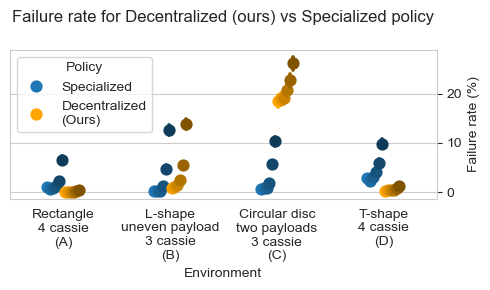

In [10]:
plt.figure(figsize=(5, 3))

policies = [
    ('Number4', 'Rectangle\n4 cassie'),
    ('PositionB', 'T-shape\n4 cassie'),
    ('ShapeA', 'L-shape\nuneven payload\n3 cassie\n'),
    ('WeightC', 'Circular disc\ntwo payloads\n3 cassie\n'),
    ('trained_3_torque_joint_force_randomize_weight', 'Decentralized\n(ours)'),
]

policies = OrderedDict(policies)

df_ = df.copy()

df_ = df_[df_.policy.isin(policies.keys())]

# Name all specialized policies as specialized
df_.loc[df_.policy.isin(['Number4', 'PositionB', 'ShapeA', 'WeightC']), 'policy'] = 'specialized'

df_['failure_rate'] = (df_['episode_length'] < 1000).astype(int) * 100.0

df_['policy_force'] = df_['policy'] + '_' + df_['force'].astype(str)

base_colors = {'specialized': 'tab:blue',
               'trained_3_torque_joint_force_randomize_weight': 'orange'}

# Create a list of colors with varying brightness
palette = []
for cat in df_.policy.unique():
    for val in df_.force.unique():
        # Vary brightness by changing the intensity
        color = sns.color_palette([base_colors[cat]], n_colors=1)[0]
        palette.append(tuple(np.array(color) * (1 - val / 200)))

# Create a dictionary mapping the combined values to the colors
combined_hue_palette = {f'{cat}_{val}': palette[i] for i, (cat, val) in
                        enumerate([(c, v) for c in df_.policy.unique() for v in df_.force.unique()])}

hue_order = [f'{cat}_{val}' for cat in sorted(df_.policy.unique()) for val in sorted(df_.force.unique())]

terrains = OrderedDict([
    ('cassiepede_rectangle', 'Rectangle\n4 cassie\n(A)'),
    ('cassiepede_shape_a', 'L-shape\nuneven payload\n3 cassie\n(B)'),
    ('cassiepede_weight_c', 'Circular disc\ntwo payloads\n3 cassie\n(C)'),
    ('cassiepede_t_shape_b', 'T-shape\n4 cassie\n(D)')]
)

ax = sns.pointplot(data=df_, x='terrain',
                   y='failure_rate', hue='policy_force', errorbar=('ci', 95), linestyles='none',
                   dodge=True,
                   hue_order=hue_order,
                   palette=combined_hue_palette,
                   order=terrains.keys())

ax.set_ylabel('Failure rate (%)')
ax.set_xlabel('Environment')

handles, labels = ax.get_legend_handles_labels()

order_idx = [0, 6]

handles = [handles[i] for i in order_idx]
labels = [labels[i] for i in order_idx]

ax.legend(handles=handles, labels=['Specialized', 'Decentralized\n(Ours)'], title='Policy')

ax.yaxis.set_major_formatter(lambda x, pos: f'{x:g}')

ax.set_xticklabels(terrains.values(), rotation=0, ha='center')

ax.set_title('Failure rate for Decentralized (ours) vs Specialized policy', pad=20)

ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')


plt.tight_layout()
plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.savefig('plot.pdf', dpi=300, bbox_inches='tight')


## XY drift across different policies

/var/folders/hn/tndm9dyn3dd0xbtnwgv3m9cr0000gn/T/ipykernel_14279/340917250.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['A', 'B', 'C', 'D'], rotation=0, ha='center')
/var/folders/hn/tndm9dyn3dd0xbtnwgv3m9cr0000gn/T/ipykernel_14279/340917250.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['A', 'B', 'C', 'D'], rotation=0, ha='center')


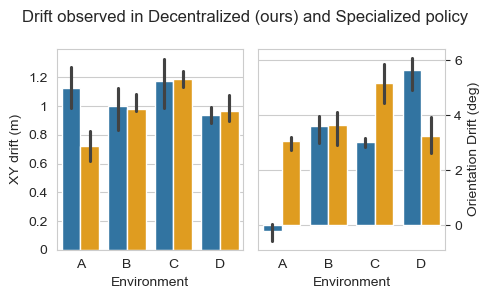

In [4]:
# Group and aggregate
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(5, 3))

policies = [
    ('Number4', 'Rectangle\n4 cassie'),
    ('PositionB', 'T-shape\n4 cassie'),
    ('ShapeA', 'L-shape\nuneven payload\n3 cassie\n'),
    ('WeightC', 'Circular disc\ntwo payloads\n3 cassie\n'),
    ('trained_3_torque_joint_force_randomize_weight', 'Decentralized\n(ours)'),
]

policies = OrderedDict(policies)

df_ = df.copy()

df_ = df_[df_.policy.isin(policies.keys())]

# Name all specialized policies as specialized
df_.loc[df_.policy.isin(['Number4', 'PositionB', 'ShapeA', 'WeightC']), 'policy'] = 'specialized'

df_['failure_rate'] = (df_['episode_length'] < 1000).astype(int) * 100.0

df_ = df_.groupby(
    ['policy', 'terrain', 'command_x', 'command_y', 'command_t']).agg(
    {'odometry_x': 'mean', 'odometry_y': 'mean', 'orientation_error': 'mean', 'episode_length': 'mean'})

# Reset index to create table from grouped table
df_ = df_.reset_index()

df_.loc[df_['command_x'] == 1, 'odometry_x'] = 20 - df_.loc[df_['command_x'] == 1, 'odometry_x']
df_.loc[df_['command_y'] == 0.25, 'odometry_y'] = 5 - df_.loc[df_['command_y'] == 0.25, 'odometry_y']
df_['orientation_error'] = -df_['orientation_error']

df_['drift_xy'] = (np.sqrt(df_['odometry_x'] ** 2 + df_['odometry_y'] ** 2))  #+ df_['orientation_error'].abs()

custom_palette = {
    'specialized': 'tab:blue',
    'trained_3_torque_joint_force_randomize_weight': 'orange',
}

terrains = OrderedDict([
    ('cassiepede_rectangle', 'Rectangle\n4 cassie\n(A)'),
    ('cassiepede_shape_a', 'L-shape\nuneven payload\n3 cassie\n(B)'),
    ('cassiepede_weight_c', 'Circular disc\ntwo payloads\n3 cassie\n(C)'),
    ('cassiepede_t_shape_b', 'T-shape\n4 cassie\n(D)')]
)

sns.barplot(data=df_, x='terrain', y='drift_xy', hue='policy', errorbar=('ci', 30), palette=custom_palette, ax=ax1,
            order=terrains.keys())

sns.barplot(data=df_, x='terrain', y='orientation_error', hue='policy', errorbar=('ci', 30), palette=custom_palette,
            ax=ax2, order=terrains.keys())

ax1.set_ylabel('XY drift (m)')
ax2.set_ylabel('Orientation Drift (deg)')

ax1.set_xlabel('Environment')
ax2.set_xlabel('Environment')

ax1.yaxis.set_major_formatter(lambda x, pos: f'{x:g}')
ax2.yaxis.set_major_formatter(lambda x, pos: f'{x:g}')

# ax1.set_xticklabels(['Quadrapedal', 'Hexapedal'], rotation=0, ha='center')
# ax2.set_xticklabels(['Quadrapedal', 'Hexapedal'], rotation=0, ha='center')


ax1.set_xticklabels(['A', 'B', 'C', 'D'], rotation=0, ha='center')
ax2.set_xticklabels(['A', 'B', 'C', 'D'], rotation=0, ha='center')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')

ax1.legend_.remove()
ax2.legend_.remove()

fig.suptitle('Drift observed in Decentralized (ours) and Specialized policy')

plt.tight_layout()
plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.savefig('plot.pdf', dpi=300, bbox_inches='tight')

## Boxplot

/var/folders/hn/tndm9dyn3dd0xbtnwgv3m9cr0000gn/T/ipykernel_14279/1284645764.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['A', 'B', 'C', 'D'], rotation=0, ha='center')
/var/folders/hn/tndm9dyn3dd0xbtnwgv3m9cr0000gn/T/ipykernel_14279/1284645764.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['A', 'B', 'C', 'D'], rotation=0, ha='center')


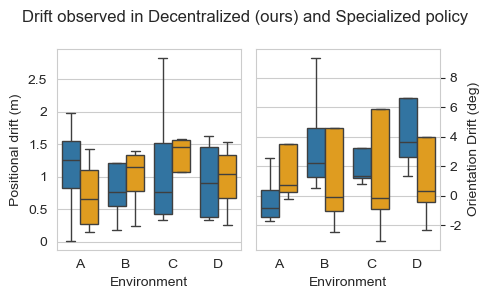

In [9]:
# Group and aggregate
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(5, 3))

policies = [
    ('Number4', 'Rectangle\n4 cassie'),
    ('PositionB', 'T-shape\n4 cassie'),
    ('ShapeA', 'L-shape\nuneven payload\n3 cassie\n'),
    ('WeightC', 'Circular disc\ntwo payloads\n3 cassie\n'),
    ('trained_3_torque_joint_force_randomize_weight', 'Decentralized\n(ours)'),
]

policies = OrderedDict(policies)

df_ = df.copy()

df_ = df_[df_.policy.isin(policies.keys())]

# Name all specialized policies as specialized
df_.loc[df_.policy.isin(['Number4', 'PositionB', 'ShapeA', 'WeightC']), 'policy'] = 'specialized'

df_['failure_rate'] = (df_['episode_length'] < 1000).astype(int) * 100.0

df_ = df_.groupby(
    ['policy', 'terrain', 'command_x', 'command_y', 'command_t']).agg(
    {'odometry_x': 'mean', 'odometry_y': 'mean', 'orientation_error': 'mean', 'episode_length': 'mean'})

# Reset index to create table from grouped table
df_ = df_.reset_index()

df_.loc[df_['command_x'] == 1, 'odometry_x'] = 20 - df_.loc[df_['command_x'] == 1, 'odometry_x']
df_.loc[df_['command_y'] == 0.25, 'odometry_y'] = 5 - df_.loc[df_['command_y'] == 0.25, 'odometry_y']
df_['orientation_error'] = -df_['orientation_error']

df_['drift_xy'] = (np.sqrt(df_['odometry_x'] ** 2 + df_['odometry_y'] ** 2))  #+ df_['orientation_error'].abs()

custom_palette = {
    'specialized': 'tab:blue',
    'trained_3_torque_joint_force_randomize_weight': 'orange',
}

terrains = OrderedDict([
    ('cassiepede_rectangle', 'Rectangle\n4 cassie\n(A)'),
    ('cassiepede_shape_a', 'L-shape\nuneven payload\n3 cassie\n(B)'),
    ('cassiepede_weight_c', 'Circular disc\ntwo payloads\n3 cassie\n(C)'),
    ('cassiepede_t_shape_b', 'T-shape\n4 cassie\n(D)')]
)

# sns.barplot(data=df_, x='terrain', y='drift_xy', hue='policy', errorbar=('ci', 30), palette=custom_palette, ax=ax1,
#             order=terrains.keys())
# 
# sns.barplot(data=df_, x='terrain', y='orientation_error', hue='policy', errorbar=('ci', 30), palette=custom_palette,
#             ax=ax2, order=terrains.keys())

sns.boxplot(data=df_,
            x='terrain', y='drift_xy', hue='policy', showfliers=False, ax=ax1, palette=custom_palette, order=terrains.keys(), dodge=True)

sns.boxplot(data=df_,
            x='terrain', y='orientation_error', hue='policy', showfliers=False, ax=ax2, palette=custom_palette, order=terrains.keys(), dodge=True)


ax1.set_ylabel('Positional drift (m)')
ax2.set_ylabel('Orientation Drift (deg)')

ax1.set_xlabel('Environment')
ax2.set_xlabel('Environment')

ax1.yaxis.set_major_formatter(lambda x, pos: f'{x:g}')
ax2.yaxis.set_major_formatter(lambda x, pos: f'{x:g}')

# ax1.set_xticklabels(['Quadrapedal', 'Hexapedal'], rotation=0, ha='center')
# ax2.set_xticklabels(['Quadrapedal', 'Hexapedal'], rotation=0, ha='center')


ax1.set_xticklabels(['A', 'B', 'C', 'D'], rotation=0, ha='center')
ax2.set_xticklabels(['A', 'B', 'C', 'D'], rotation=0, ha='center')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')

ax1.legend_.remove()
ax2.legend_.remove()

fig.suptitle('Drift observed in Decentralized (ours) and Specialized policy')

plt.tight_layout()
plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.savefig('plot.pdf', dpi=300, bbox_inches='tight')